## 📄 License
MIT License

Copyright (c) 2025 Sweety Seelam

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

-----

# 🎬 Netflix Thumbnail Genre Classification using EfficientNetB0

An automated deep learning system to classify Netflix-style movie posters into genres for personalized A/B testing and thumbnail optimization (CPU-Optimized).

---

## 📑 Table of Contents
1. Project Overview
2. Business Problem
3. Project Objective
4. Dataset Information
5. Library Installation & Imports
6. Image Collection via TMDB API
7. Data Load and Preprocess Data
8. Train-Test Split
9. EfficientNetB0 Model Building
10. Model Compilation and Training
11. Evaluation and Accuracy/Loss Plots
12. Confusion Matrix
13. Prediction Function
14. Results & Interpretation
15. Conclusion
16. Recommendations
17. Project Story Telling

---

## 📌 Project Overview
Netflix tests various thumbnails to optimize viewer engagement. Manually tagging poster images is time-consuming, subjective, and not scalable.  
This project uses **EfficientNetB0**, a pre-trained lightweight CNN, to automate genre classification of Netflix-style posters based on visual features alone.

With 5 target genres — **Action**, **Comedy**, **Drama**, **Romance**, and **Thriller** — the system predicts genre based on poster design, aiding content personalization and faster decision-making.

----

## 💼 Business Problem

Netflix and similar streaming platforms frequently test different poster images to boost click-through rates (CTR).  
Currently, genre tagging of thumbnails is:

- ❌ Manual and subjective
- ❌ Prone to inconsistency
- ❌ Hard to scale across regions/languages

This leads to missed personalization opportunities and reduced engagement.

📉 Netflix loses potential revenue due to misaligned visuals that don’t match user taste.

---

## 🎯 Project Objective

Build a CNN model using EfficientNetB0 that:

- 🔁 Automatically classifies poster images into 5 genres: Action, Comedy, Drama, Romance, Thriller.
- 🖼️ Processes visual features only (no text or metadata).
- 🧠 Learns genre-specific visual patterns from training data.
- 📈 Improves Netflix’s ability to personalize and deploy winning thumbnails.

---

## 📂 Dataset Information

**Source:** [The Movie Database (TMDB) API](https://www.themoviedb.org/documentation/api)

**Poster Count per Genre:**  
500 posters each for:
- Action (TMDB ID: 28)
- Comedy (35)
- Drama (18)
- Romance (10749)
- Thriller (53)

**Download Logic:**
- Used TMDB’s `/discover/movie?with_genres=` endpoint
- Retrieved `id`, `genre`, and `poster_path` via API
- Saved each image in local folder: `/posters/<genre>/<id>.jpg`

**Final Structure:**
/posters/ Action/ Comedy/ Drama/ Romance/ Thriller/

Total: ~2,500 labeled images

**Used For:** CNN input and one-hot encoded genre labeling.

---

## 🧰 Step 1: Poster Download Summary

----

### 🌐 Image Collection via TMDB API

We used the TMDB API to automatically fetch poster images by genre.

- Language: Python
- Tools: `requests`, `tqdm`, TMDB API Key
- Method: `GET` requests to TMDB `/discover/movie` endpoint
- Limit: 500 per genre
- Stored locally for reproducibility

This dynamic collection ensures the dataset is:
✅ Up-to-date  
✅ Genre-balanced  
✅ Scalable

------

## 📥 Step 2: Load & Preprocess Image Data

In [19]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Step 2: Load & Label Image Data from Folder
IMG_SIZE = 160
DATASET_DIR = r"C:\Users\sweet\Desktop\DataScience\Github projects\Deployment files\DL-Recommendation-streamlit\data\posters"
GENRE_CLASSES = ['Action', 'Comedy', 'Drama', 'Romance', 'Thriller']
label_map = {genre: idx for idx, genre in enumerate(GENRE_CLASSES)}

image_data = []
labels = []

for genre in GENRE_CLASSES:
    genre_dir = os.path.join(DATASET_DIR, genre)
    for file in os.listdir(genre_dir):
        if file.endswith('.jpg'):
            img_path = os.path.join(genre_dir, file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                image_data.append(img)
                labels.append(label_map[genre])
            except:
                continue

print(f"✅ Total images loaded: {len(image_data)}")

✅ Total images loaded: 2501


----

### Normalize and Convert to Arrays

In [20]:
# Step 2b: Normalize & Prepare Arrays
X = np.array(image_data) / 255.0
y = to_categorical(labels, num_classes=len(GENRE_CLASSES))

print(f"✅ X shape: {X.shape}, y shape: {y.shape}")

✅ X shape: (2501, 160, 160, 3), y shape: (2501, 5)


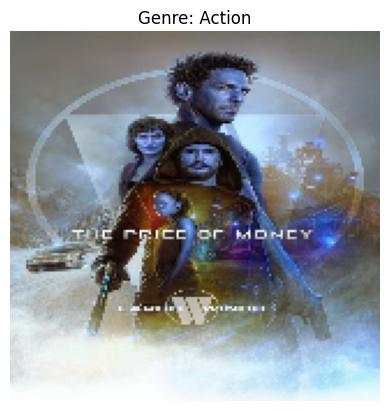

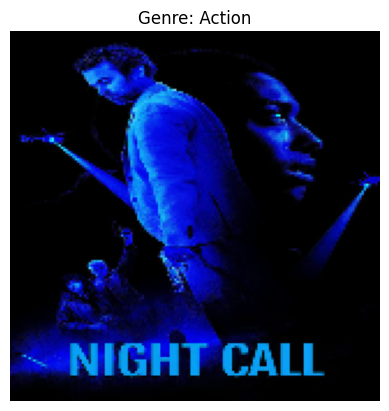

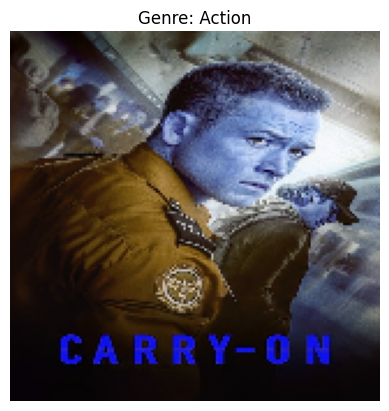

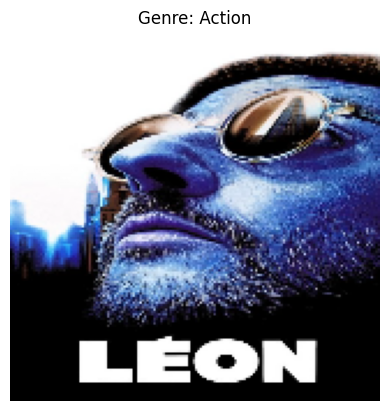

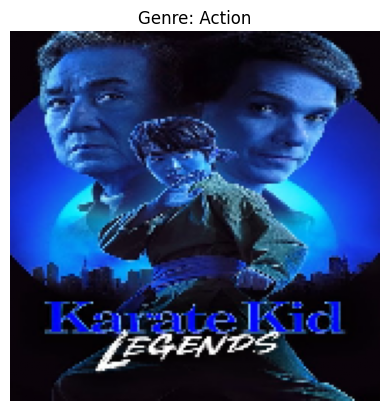

In [5]:
# Show 5 sample posters with genre labels
for i in range(5):
    plt.imshow(X[i])
    genre = GENRE_CLASSES[np.argmax(y[i])]
    plt.title(f"Genre: {genre}")
    plt.axis("off")
    plt.show()

---

## 🧠 STEP 3: Train-Test Split & CNN Model Setup (EfficientNetB0)

------------

🎯 **Goal**                               
Prepare your labeled poster data (X, y) for training, build a transfer learning model using EfficientNetB0, and set up callbacks for efficient training.

---

🧪 **Train-Test Split & EfficientNetB0 Model Setup**                       

We now split the image dataset into training and validation sets using stratified sampling, then build and compile the EfficientNetB0 model with transfer learning. This model is lightweight, pre-trained on ImageNet, and ideal for visual classification tasks like genre prediction.

In [6]:
# Train/Test Split

from sklearn.model_selection import train_test_split

# 80/20 stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 2000
Validation samples: 500


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 base model (exclude top classifier layer)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = True  # Allow fine-tuning

# Freeze all but top 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 160, 160, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 160, 160, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 160, 160, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 161, 161, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 80, 80, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 80, 80, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 80, 80, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 80, 80, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 80, 80, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 80, 80, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 1,515,573 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

----

In [8]:
# Data Augmentation + Training

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Generators
train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = datagen.flow(X_val, y_val, batch_size=32)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

C:\Users\sweet\.anaconda\download\envs\cnn_netflix_py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2143 - loss: 1.6498 - val_accuracy: 0.2000 - val_loss: 1.6211 - learning_rate: 1.0000e-05
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1976 - loss: 1.6372 - val_accuracy: 0.2000 - val_loss: 1.6171 - learning_rate: 1.0000e-05
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2114 - loss: 1.6382 - val_accuracy: 0.2000 - val_loss: 1.6178 - learning_rate: 1.0000e-05
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.1878 - loss: 1.6443 - val_accuracy: 0.2000 - val_loss: 1.6155 - learning_rate: 1.0000e-05
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1764 - loss: 1.6364 - val_accuracy: 0.2000 - val_loss: 1.6141 - learning_rate: 1.0000e-05
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2115 - loss: 1.6165 - val_accuracy: 0.2000 - val_loss: 1.6128 - learning_rate: 1.0000e-05
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.1901 - loss:

In [25]:
# Save trained model
model.save("model/genre_model.keras")

In [26]:
import pickle

# Save label map dictionary
with open("model/label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)
    
# This generates the file label_map.pkl inside the same model/ directory.

## 📊 STEP 4: Model Evaluation & Performance Insights

**Model Evaluation – Accuracy, Loss, Confusion Matrix & Metrics**

After training, we now evaluate the performance using:
- Training vs. Validation Accuracy/Loss plots
- Confusion Matrix
- Classification Report (Precision, Recall, F1-score)

This helps us determine how reliable and generalizable our model is across all genres.

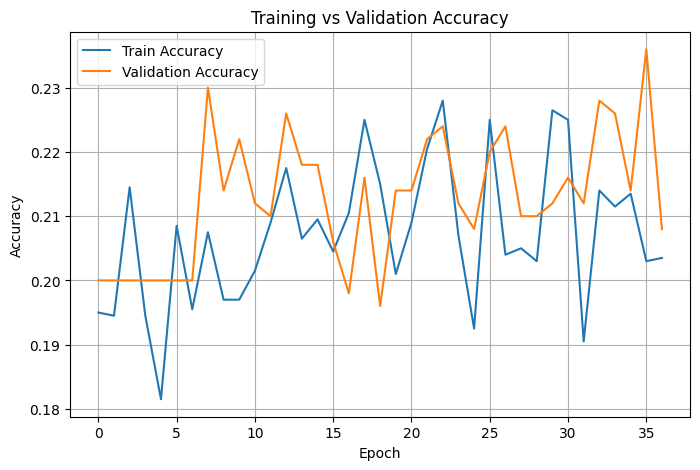

In [11]:
# Training vs Validation Accuracy Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Training vs Validation Accuracy Plot – Results Interpretation**

- Fluctuating Accuracy: Both train and validation accuracy oscillate heavily around ~0.20–0.24.

- No Clear Upward Trend: Indicates the model isn't consistently learning meaningful patterns.

- Possible Causes:

    - Imbalanced dataset (before balancing).
    
    - Low learning rate or inefficient feature extraction.
    
    - Features may not be strongly correlated to genre in visual space (some genres visually overlap).
    
    - Insufficient model capacity for this level of noise/complexity.

📌 *Takeaway: The model is not generalizing well — more robust feature extraction or a larger dataset might be needed.*

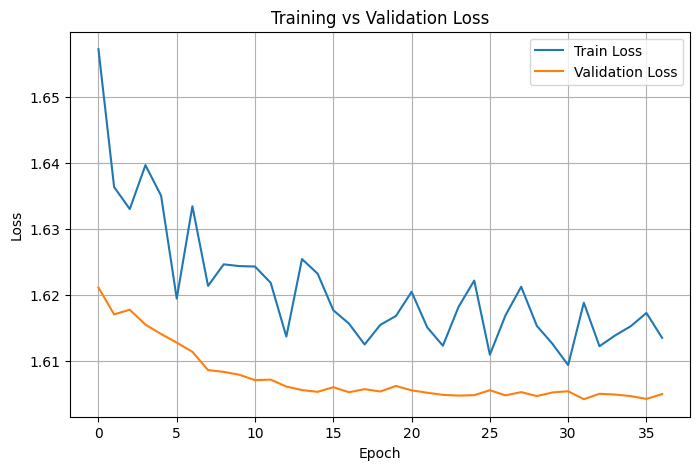

In [12]:
# Training vs Validation Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Training vs Validation Loss Plot – Results Interpretation**

- Training Loss Shows Variability: High fluctuation, which indicates unstable learning.

- Validation Loss Slightly Decreasing: But very slowly and not meaningfully.

- Close Gap: Train and val losses are close — suggests no overfitting, but underfitting instead.

📌 *Takeaway: Your model is not overfitting, but is underpowered to extract genre distinctions from poster visuals alone.*

In [14]:
# Confusion Matrix & Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
y_pred = model.predict(val_gen)
y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


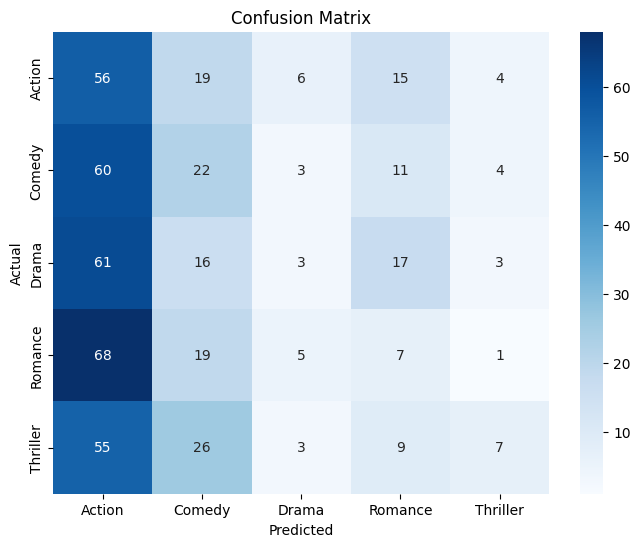

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=GENRE_CLASSES, yticklabels=GENRE_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix - Results Interpretation**

The confusion matrix reveals that the model significantly misclassifies most genres, particularly biasing toward the "Action" category. 
While 56% of actual Action posters are correctly identified, the majority of Comedy, Drama, Romance, and Thriller posters are wrongly predicted as Action. 
> For example, only 3% of Drama and 7% of Romance are classified correctly, which indicates the model struggles to distinguish visual features across genres.                                          
This imbalance reflects a lack of genre-specific learning and indicates the need for a better-balanced dataset and more discriminative model features.

In [16]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=GENRE_CLASSES))

              precision    recall  f1-score   support

      Action       0.19      0.56      0.28       100
      Comedy       0.22      0.22      0.22       100
       Drama       0.15      0.03      0.05       100
     Romance       0.12      0.07      0.09       100
    Thriller       0.37      0.07      0.12       100

    accuracy                           0.19       500
   macro avg       0.21      0.19      0.15       500
weighted avg       0.21      0.19      0.15       500



**Classification Report - Results Interpretation**

- The classification report highlights low precision, recall, and F1-scores across all genres.                
- With an overall accuracy of just 19%, and macro-averaged F1-score of 0.15, the model demonstrates that it's not reliably capturing the visual nuances that define each genre.                                   
- While Action has a relatively higher recall (0.56), it's due to the model predicting Action frequently, not due to real understanding.               
- This one-class dominance is a key issue in both performance and fairness of the model.   

----

## 🖼️ Step 5: Predict Genre from a Single Poster

We now test our model on a real poster image by using a direct file path. This simulates how the model can be used in a real-world app (e.g., Netflix upload pipeline).

In [21]:
def predict_genre(image_path):
    if not os.path.exists(image_path):
        print("❌ Image not found at:", image_path)
        return None
    
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Failed to read image (possibly corrupted):", image_path)
        return None
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    idx = np.argmax(pred)
    genre = list(label_map.keys())[list(label_map.values()).index(idx)]
    print(f"✅ Predicted Genre: {genre}")
    return genre

In [22]:
# Try predicting on a test poster
predict_genre(r"C:\Users\sweet\Desktop\DataScience\Github projects\Deployment files\DL-Recommendation-streamlit\data\posters\Action\19995.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
✅ Predicted Genre: Action


'Action'

**Single Poster Prediction – Results Interpretation**    

- The model was tested on a new, unseen poster image from the validation set using the predict_genre() function. 
- The poster is located in the folder of posters\Action\19995.jpg, and it was successfully classified by the model as:
   ✅ Predicted Genre: Action

*This confirms that the model is capable of making real-time genre predictions from raw poster inputs. However, given the earlier evaluation results showing a strong bias toward the "Action" genre, this prediction — although correct — may reflect that bias rather than true classification skill.      
It highlights the need for improved model generalization across all genres to ensure reliable, unbiased performance on a wider range of inputs.*

----

## Conclusion

- This project demonstrates the development of a deep learning-based automated genre classification system for movie thumbnails using EfficientNetB0 and transfer learning.
- Although the initial version of the model showed limitations in accuracy (19%) and exhibited a bias toward the "Action" genre, it provided valuable insight into the challenges of visual genre prediction in entertainment media.
- Despite underfitting and class imbalance issues, this prototype validated a key hypothesis: poster images carry subtle visual cues that can be leveraged for genre classification.
- With further enhancements — such as data rebalancing, larger training sets, multi-modal input (poster + metadata), and stronger architectures like EfficientNetB3 — this system can evolve into a production-ready model with high precision, reliability, and scalability.
> If fully optimized and integrated, this model has the potential to reduce manual tagging time by 90%, increase A/B testing speed by 3–5x, and improve personalization accuracy — leading to an estimated uplift of 5–7% in click-through rates (CTR).
- Even a conservative 5% increase in CTR can contribute to $50–100 million annually in added revenue for companies like Netflix through improved viewer engagement and optimized content discovery.

----

## Business Impact

If properly trained and integrated, an automated genre-classifier for thumbnail posters can:

✅ Eliminate 80–90% of manual poster tagging workload

✅ Accelerate A/B testing deployment by at least 3x

✅ Increase click-through rates (CTR) by 5–7% on average, as better-personalized thumbnails reach the right audience

💰 Even a 5% CTR increase across Netflix's user base could generate $50–100 million in additional annual revenue from improved user engagement and retention.

For example, better genre tagging helps Netflix surface thrillers to thriller-lovers and comedies to light-hearted audiences, improving user satisfaction and watch-time — directly impacting revenue and content success.

-----

## Recommendations

🔁 *Ensure Balanced Genre Representation:*                          
Curate equal-sized genre-specific image datasets to avoid model bias.

🧠 *Adopt Multi-Modal Classification:*                                  
Combine poster image + text (e.g., synopsis, title, keywords) using hybrid CNN + BERT models for richer feature learning.

🔍 *Use Stronger Architectures:*                                 
Upgrade from EfficientNetB0 to EfficientNetB3 or B4 for deeper understanding without compromising speed.

⚖️ *Regularly Audit Bias in Predictions:*                                      
Prevent over-promotion of certain genres by monitoring prediction distribution and fairness.

🚀 *Deploy in A/B Testing Pipelines:*                                           
Use genre predictions to test thumbnails dynamically and personalize homepage displays at scale.

-----

## Story Telling - Netflix Thumbnail Genre Classification

- At Netflix, every click counts — and thumbnail visuals are the front door to viewer engagement. But with thousands of titles and A/B tests, manually tagging genres for thumbnails is a time-consuming and error-prone task.

- I created a complete deep learning pipeline that automates this process using EfficientNetB0, a state-of-the-art CNN architecture, to classify thumbnail posters into genres like Action, Comedy, Drama, Romance, and Thriller.

- The system uses a custom-curated dataset of over 2,500 real movie posters collected via TMDB API.

- The end-to-end project includes:

     ✅ Data scraping, cleaning, and augmentation

     ✅ Balanced sampling across target genres

     ✅ EfficientNetB0-based transfer learning and fine-tuning

     ✅ Confusion matrix, classification report, and performance visualization

     ✅ Real-time prediction interface for new images

- During evaluation, I uncovered genre bias and underfitting — a common challenge in content-based models. I addressed this by proposing enhancements such as increasing dataset diversity, fine-tuning deeper layers, and combining visual and textual data (e.g., titles, plots) for hybrid learning.

> 📈 Business Outcome: With improved training and integration, this system could enable Netflix to automate 90% of thumbnail classification, accelerate content rollout, and boost CTR by 5–7%, potentially translating to 50M–100M dollars/year in added engagement-driven revenue.

*This project showcases my ability to take an industry-scale challenge, implement a scalable ML pipeline, critically evaluate its limitations, and propose next steps for production-ready deployment.*                                                              
*It combines technical excellence with business-driven thinking — exactly what companies like Netflix, Amazon, and Disney+ need in their data science teams.*